# Data Science Internship at Widhya

## Mission: Build Neural Network 

#### Importing required libraries

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import random
import pandas as pd


Bad key "text.kerning_factor" on line 4 in
C:\Users\HRISHIKESH\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
lr = 0.1
lmbda = 0.01
beta = 0.09
layers_dims = []

#### Creating class ANN

In [26]:
class ANN(object):
   
    def __init__(self, layers_dims, learning_rate=lr, lmbda=lmbda, beta=beta):
        self.parameters = {}
        self.grads = {}
        self.layers_dims = layers_dims
        self.train_cost = []
        self.val_cost = []
        self.test_cost = []
        self.reg = []
        self.momentum = []
        self.learning_rate = learning_rate
        self.lmbda = lmbda
        self.beta = beta

    def tanhx(self, data):
        output = np.tanh(data)
        return output

    def tanhx_der(self, data):
        return 1 - self.tanhx(data)**2

    def io_normalization(self, data):
        for i in data.columns:
            data[i] = (2*data[i] - data.max()[i] - data.min()[i])/(data.max()[i] - data.min()[i])
        return data

    def initialize_parameters(self, layer_dims):
        for i in range(1,len(layer_dims)):
            self.parameters["W" + str(i)] = np.random.randn(layer_dims[i],layer_dims[i-1])*0.2
            self.parameters["b" + str(i)] = np.zeros(shape=(layer_dims[i],1))

        return self.parameters


    def feedforward(self, input_layer, parameters):
        activations = [input_layer]
        L = len(parameters)//2
        for i in range(1, L):
            activation = self.tanhx(np.dot(parameters["W" + str(i)], activations[i-1]) + parameters["b" + str(i)])
            activations += [activation]

        output = self.tanhx(np.dot(parameters["W" + str(L)],activations[L-1]) + parameters["b" + str(L)])
        activations += [output]
        print("FeedForward propgation is done\n")
        return output, activations

    def cost_function(self, predictions, outputs):
        print("Found cost\n")
        self.train_cost = (1/1000)*(outputs-predictions)**2/2
        return (1/1000)*(outputs-predictions)**2/2

    def cost_validation(self, predictions, outputs):
        print("Found cost\n")
        self.val_cost = (1/1000)*((outputs-predictions)**2/2)
        return (1/1000)*((outputs-predictions)**2/2)

    def backprop(self, actual_outputs, outputs, activation_cache):
        L = len(self.parameters)//2
        self.grads["dZ" + str(L)] = outputs - actual_outputs
        self.grads["dW" + str(L)] = (1/1000)*np.matmul(self.grads["dZ" + str(L)], activation_cache[L-1].T)
        self.grads["db" + str(L)] = (1/1000)*np.sum(self.grads["dZ" + str(L)], axis = 1, keepdims = True)

        for layer in range(L-1, 0, -1):
            self.grads["dZ" + str(layer)] = np.multiply(np.dot(self.parameters["W" + str(layer+1)].T, self.grads["dZ" + str(layer+1)]), self.tanhx_der(activation_cache[layer]))
            self.grads["dW" + str(layer)] = (1/1000)*np.matmul(self.grads["dZ" + str(layer)], activation_cache[layer - 1].T)
            self.grads["db" + str(layer)] = (1/1000)*np.sum(self.grads["dZ" + str(layer)], axis = 1, keepdims=True)

        print("Backpropogation is done\n")
        return self.grads

    def regularization(self, grad_comp, param_comp):
        dW = learning_rate*(grad_comp - lmbda*abs(param_comp))
        return dW

    def momentum_term(self, grad_comp, param_comp):
        dW = beta*grad_comp + (beta-1)*(self.regularization(grad_comp, param_comp))
        return dW

    def update_parameters(self, learning_rate):
        """
        Takes care of regularization and momentum too
        """
        for i in range(0, len(self.parameters)//2):
            #print(i)
            #dW = self.momentum_term(self.grads["dW" + str(i+1)], self.parameters["W" + str(i+1)])
            self.parameters["W" + str(i+1)] = self.parameters["W" + str(i+1)] - learning_rate*self.grads['dW' + str(i+1)]
            self.parameters["b" + str(i+1)] = self.parameters["b" + str(i+1)] - learning_rate*self.grads["db" + str(i+1)]
        print("Parameters Updated\n")
        return self.parameters


    def train_model(self, input, output, epochs):
        parameters = self.initialize_parameters(self.layers_dims)

        actual_output = output.values.reshape(self.layers_dims[-1], output.shape[0])
        inputs = input.values.reshape(self.layers_dims[0], input.shape[0])

        for epoch in range(epochs):
            
            outputs, activation_cache = self.feedforward(inputs, parameters)

            cost = self.cost_function(outputs, actual_output)

            grads = self.backprop(actual_output, outputs, activation_cache)

            parameters = self.update_parameters(lr)

            output = "Epoch %r Error %r"%(epoch+1, round(cost.mean(),8))
            print(output)
            print('--------------------------------------------------------------------------------------\n')

        return parameters

    def split_dataset(self, data):
        actual = data
        data_indices = [i for i in range(len(data))]
        test_indices = random.sample(range(len(data)), int(0.1*len(data)))
        data_indices = np.delete(data_indices, test_indices)

        train = []
        val = []
        test = []
        data = data.values.tolist()
        for i in range(0,len(data)):
            if(i in data_indices):
                train += [data[i]]
            else:
                test += [data[i]]
        train = []
        for i in range(0, len(data_indices)):
            if(i%5==0):
                val += [data[i]]
            else:
                train += [data[i]]

        train = pd.DataFrame(train, columns = actual.columns)
        val = pd.DataFrame(val, columns = actual.columns)
        test = pd.DataFrame(test, columns = actual.columns)
        return train, val, test

    def rms_error(self, outputs, predictions):
        ms_sum = 0
        for op, pred in zip(outputs, predictions):
            ms_sum += (outputs[op] - predictions[pred])**2
        rmse = ms_sum/len(outputs)
        return rmse


#### Creating final neural_net function 

In [30]:
def neural_net():
    data = pd.read_csv("sin_data.csv")

    ann = ANN([1,25,1])

    train, val, test = ann.split_dataset(data)
    train_x, train_y = pd.DataFrame(train["x"]), pd.DataFrame(train["sin_x"])
    val_ip, val_op = pd.DataFrame(val["x"]), pd.DataFrame(val["sin_x"])
    test_ip, test_op = pd.DataFrame(test["x"]), pd.DataFrame(test["sin_x"])
    parameters = ann.train_model(train_x, train_y, epochs=8000)

    print(parameters["b1"], parameters["b2"])
    all_out = np.array([])
    all_in = np.array([])

    hidden_layer = ann.tanhx(np.dot(parameters["W1"],train_x.T) + parameters["b1"])
    output_layer = ann.tanhx(np.dot(parameters["W2"],hidden_layer) + parameters["b2"])
    
    all_out = np.append(all_out, output_layer)
    all_in = np.append(all_in, train_x)
    #print(ann.rms_error(train_y, output_layer))
    
    ### Grphical Representation
    plt.plot(train["x"],train["sin_x"],'r')
    plt.plot(all_in,all_out,'b')
    plt.show()

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1 Error 0.00025809
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2 Error 0.00024981
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3 Error 0.00024709
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4 Error 0.00024455
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5 Error 0.00024207
------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 43 Error 0.00017089
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 44 Error 0.00016955
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 45 Error 0.00016823
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 46 Error 0.00016693
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 47 Error 0.00016565
-------------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 117 Error 0.00010288
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 118 Error 0.00010223
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 119 Error 0.00010158
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 120 Error 0.00010094
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 121 Error 0.00010031
--------------------------------------------------------------------------------------

FeedForward propgation i

Backpropogation is done

Parameters Updated

Epoch 190 Error 6.646e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 191 Error 6.609e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 192 Error 6.572e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 193 Error 6.535e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 194 Error 6.499e-05
--------------------------------------------------------------------------------------

FeedForward propgation is don

Backpropogation is done

Parameters Updated

Epoch 265 Error 4.541e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 266 Error 4.521e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 267 Error 4.5e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 268 Error 4.48e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 269 Error 4.46e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

F

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 337 Error 3.411e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 338 Error 3.399e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 339 Error 3.387e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 340 Error 3.376e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 341 Error 3.365e-05
-------------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 425 Error 2.678e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 426 Error 2.672e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 427 Error 2.666e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 428 Error 2.661e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 429 Error 2.655e-05
--------------------------------------------------------------------------------------

FeedForward propgation is don

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 468 Error 2.475e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 469 Error 2.472e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 470 Error 2.468e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 471 Error 2.464e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 472 Error 2.46e-05
--------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 535 Error 2.287e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 536 Error 2.286e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 537 Error 2.284e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 538 Error 2.282e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 539 Error 2.28e-05
--------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 599 Error 2.204e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 600 Error 2.203e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 601 Error 2.202e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 602 Error 2.201e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 603 Error 2.201e-05
-------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 666 Error 2.177e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 667 Error 2.177e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 668 Error 2.177e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 669 Error 2.177e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 670 Error 2.177e-05
-------------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 721 Error 2.183e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 722 Error 2.183e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 723 Error 2.183e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 724 Error 2.183e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 725 Error 2.184e-05
--------------------------------------------------------------------------------------

FeedForward propgation is don

Backpropogation is done

Parameters Updated

Epoch 795 Error 2.211e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 796 Error 2.212e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 797 Error 2.212e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 798 Error 2.213e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 799 Error 2.213e-05
--------------------------------------------------------------------------------------

FeedForward propgation is don


FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 862 Error 2.247e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 863 Error 2.247e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 864 Error 2.248e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 865 Error 2.249e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 866 Error 2.249e-05
------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 935 Error 2.29e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 936 Error 2.291e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 937 Error 2.291e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 938 Error 2.292e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 939 Error 2.293e-05
--------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 977 Error 2.315e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 978 Error 2.316e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 979 Error 2.317e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 980 Error 2.317e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 981 Error 2.318e-05
-------------------------------------------------------------------------


Parameters Updated

Epoch 1051 Error 2.36e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1052 Error 2.36e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1053 Error 2.361e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1054 Error 2.362e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1055 Error 2.362e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpr

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1127 Error 2.403e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1128 Error 2.404e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1129 Error 2.404e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1130 Error 2.405e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1131 Error 2.406e-05
--------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 1188 Error 2.436e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1189 Error 2.437e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1190 Error 2.437e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1191 Error 2.438e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1192 Error 2.438e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

Backpropogation is done

Parameters Updated

Epoch 1248 Error 2.466e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1249 Error 2.467e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1250 Error 2.467e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1251 Error 2.468e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1252 Error 2.468e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

Parameters Updated

Epoch 1312 Error 2.495e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1313 Error 2.496e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1314 Error 2.496e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1315 Error 2.497e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1316 Error 2.497e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backp

Backpropogation is done

Parameters Updated

Epoch 1394 Error 2.528e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1395 Error 2.529e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1396 Error 2.529e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1397 Error 2.53e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1398 Error 2.53e-05
--------------------------------------------------------------------------------------

FeedForward propgation is 

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1439 Error 2.544e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1440 Error 2.545e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1441 Error 2.545e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1442 Error 2.545e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1443 Error 2.546e-05
--------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1482 Error 2.558e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1483 Error 2.559e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1484 Error 2.559e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1485 Error 2.559e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1486 Error 2.56e-05
---------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 1548 Error 2.578e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1549 Error 2.578e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1550 Error 2.578e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1551 Error 2.579e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1552 Error 2.579e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

Backpropogation is done

Parameters Updated

Epoch 1618 Error 2.596e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1619 Error 2.596e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1620 Error 2.596e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1621 Error 2.596e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1622 Error 2.597e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1686 Error 2.611e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1687 Error 2.611e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1688 Error 2.611e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1689 Error 2.611e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1690 Error 2.612e-05
--------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1727 Error 2.619e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1728 Error 2.619e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1729 Error 2.62e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1730 Error 2.62e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1731 Error 2.62e-05
-----------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 1794 Error 2.632e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1795 Error 2.632e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1796 Error 2.632e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1797 Error 2.632e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1798 Error 2.632e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

Backpropogation is done

Parameters Updated

Epoch 1870 Error 2.644e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1871 Error 2.644e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1872 Error 2.644e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1873 Error 2.644e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1874 Error 2.645e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1948 Error 2.655e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1949 Error 2.655e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1950 Error 2.655e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1951 Error 2.656e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1952 Error 2.656e-05
--------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 1996 Error 2.661e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1997 Error 2.662e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1998 Error 2.662e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 1999 Error 2.662e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2000 Error 2.662e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2063 Error 2.67e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2064 Error 2.67e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2065 Error 2.67e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2066 Error 2.67e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2067 Error 2.67e-05
-------------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 2140 Error 2.678e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2141 Error 2.678e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2142 Error 2.678e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2143 Error 2.678e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2144 Error 2.678e-05
--------------------------------------------------------------------------------------

FeedForward propgation i


Found cost

Backpropogation is done

Parameters Updated

Epoch 2222 Error 2.686e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2223 Error 2.686e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2224 Error 2.686e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2225 Error 2.686e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2226 Error 2.686e-05
--------------------------------------------------------------------------------------

FeedForward

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2301 Error 2.693e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2302 Error 2.693e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2303 Error 2.693e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2304 Error 2.693e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2305 Error 2.693e-05
--------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 2369 Error 2.698e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2370 Error 2.699e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2371 Error 2.699e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2372 Error 2.699e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2373 Error 2.699e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2442 Error 2.704e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2443 Error 2.704e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2444 Error 2.704e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2445 Error 2.704e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2446 Error 2.704e-05
--------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 2527 Error 2.71e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2528 Error 2.71e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2529 Error 2.71e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2530 Error 2.71e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2531 Error 2.71e-05
--------------------------------------------------------------------------------------

FeedForward propgation is don

Backpropogation is done

Parameters Updated

Epoch 2602 Error 2.714e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2603 Error 2.714e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2604 Error 2.714e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2605 Error 2.714e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2606 Error 2.714e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2672 Error 2.718e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2673 Error 2.718e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2674 Error 2.718e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2675 Error 2.718e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2676 Error 2.718e-05
--------------------------------------------------------------------

Parameters Updated

Epoch 2740 Error 2.721e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2741 Error 2.721e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2742 Error 2.722e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2743 Error 2.722e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2744 Error 2.722e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backp


FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2811 Error 2.725e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2812 Error 2.725e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2813 Error 2.725e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2814 Error 2.725e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2815 Error 2.725e-05
-------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 2880 Error 2.728e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2881 Error 2.728e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2882 Error 2.728e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2883 Error 2.728e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2884 Error 2.728e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2949 Error 2.731e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2950 Error 2.731e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2951 Error 2.731e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2952 Error 2.731e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 2953 Error 2.731e-05
--------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3018 Error 2.733e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3019 Error 2.733e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3020 Error 2.733e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3021 Error 2.733e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3022 Error 2.733e-05
--------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3086 Error 2.735e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3087 Error 2.735e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3088 Error 2.736e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3089 Error 2.736e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3090 Error 2.736e-05
--------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 3171 Error 2.738e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3172 Error 2.738e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3173 Error 2.738e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3174 Error 2.738e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3175 Error 2.738e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

Backpropogation is done

Parameters Updated

Epoch 3237 Error 2.74e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3238 Error 2.74e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3239 Error 2.74e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3240 Error 2.74e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3241 Error 2.74e-05
--------------------------------------------------------------------------------------

FeedForward propgation is don


Parameters Updated

Epoch 3335 Error 2.743e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3336 Error 2.743e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3337 Error 2.743e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3338 Error 2.743e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3339 Error 2.743e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Back

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3379 Error 2.744e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3380 Error 2.744e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3381 Error 2.744e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3382 Error 2.744e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3383 Error 2.744e-05
--------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 3451 Error 2.746e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3452 Error 2.746e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3453 Error 2.746e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3454 Error 2.746e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3455 Error 2.746e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

Backpropogation is done

Parameters Updated

Epoch 3517 Error 2.747e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3518 Error 2.747e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3519 Error 2.747e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3520 Error 2.747e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3521 Error 2.747e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3581 Error 2.749e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3582 Error 2.749e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3583 Error 2.749e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3584 Error 2.749e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3585 Error 2.749e-05
--------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3643 Error 2.75e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3644 Error 2.75e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3645 Error 2.75e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3646 Error 2.75e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3647 Error 2.75e-05
-------------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 3706 Error 2.751e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3707 Error 2.751e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3708 Error 2.751e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3709 Error 2.751e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3710 Error 2.751e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3753 Error 2.752e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3754 Error 2.752e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3755 Error 2.752e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3756 Error 2.752e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3757 Error 2.752e-05
--------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 3804 Error 2.753e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3805 Error 2.753e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3806 Error 2.753e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3807 Error 2.753e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3808 Error 2.753e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3861 Error 2.754e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3862 Error 2.754e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3863 Error 2.754e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3864 Error 2.754e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3865 Error 2.754e-05
--------------------------------------------------------------------


Parameters Updated

Epoch 3905 Error 2.755e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3906 Error 2.755e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3907 Error 2.755e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3908 Error 2.755e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3909 Error 2.755e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Back


Found cost

Backpropogation is done

Parameters Updated

Epoch 3951 Error 2.756e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3952 Error 2.756e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3953 Error 2.756e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3954 Error 2.756e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 3955 Error 2.756e-05
--------------------------------------------------------------------------------------

FeedForward

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4016 Error 2.757e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4017 Error 2.757e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4018 Error 2.757e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4019 Error 2.757e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4020 Error 2.757e-05
--------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 4064 Error 2.758e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4065 Error 2.758e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4066 Error 2.758e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4067 Error 2.758e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4068 Error 2.758e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

Backpropogation is done

Parameters Updated

Epoch 4128 Error 2.759e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4129 Error 2.759e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4130 Error 2.759e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4131 Error 2.759e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4132 Error 2.759e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4206 Error 2.761e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4207 Error 2.761e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4208 Error 2.761e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4209 Error 2.761e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4210 Error 2.761e-05
--------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 4280 Error 2.762e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4281 Error 2.762e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4282 Error 2.762e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4283 Error 2.762e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4284 Error 2.762e-05
--------------------------------------------------------------------------------------

FeedForward propgation i


Parameters Updated

Epoch 4338 Error 2.763e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4339 Error 2.763e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4340 Error 2.763e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4341 Error 2.763e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4342 Error 2.763e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Back

Backpropogation is done

Parameters Updated

Epoch 4405 Error 2.764e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4406 Error 2.764e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4407 Error 2.764e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4408 Error 2.764e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4409 Error 2.764e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4474 Error 2.765e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4475 Error 2.765e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4476 Error 2.765e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4477 Error 2.765e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4478 Error 2.765e-05
--------------------------------------------------------------------


Parameters Updated

Epoch 4544 Error 2.766e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4545 Error 2.766e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4546 Error 2.766e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4547 Error 2.766e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4548 Error 2.767e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Back

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4624 Error 2.768e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4625 Error 2.768e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4626 Error 2.768e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4627 Error 2.768e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4628 Error 2.768e-05
--------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 4689 Error 2.769e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4690 Error 2.769e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4691 Error 2.769e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4692 Error 2.769e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4693 Error 2.769e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4756 Error 2.77e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4757 Error 2.77e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4758 Error 2.77e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4759 Error 2.77e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4760 Error 2.77e-05
-------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4820 Error 2.771e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4821 Error 2.771e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4822 Error 2.771e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4823 Error 2.771e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4824 Error 2.771e-05
--------------------------------------------------------------------


Found cost

Backpropogation is done

Parameters Updated

Epoch 4880 Error 2.772e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4881 Error 2.772e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4882 Error 2.772e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4883 Error 2.772e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4884 Error 2.772e-05
--------------------------------------------------------------------------------------

FeedForward

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4942 Error 2.773e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4943 Error 2.773e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4944 Error 2.773e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4945 Error 2.773e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 4946 Error 2.773e-05
--------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 5003 Error 2.774e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5004 Error 2.774e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5005 Error 2.774e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5006 Error 2.774e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5007 Error 2.774e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

Backpropogation is done

Parameters Updated

Epoch 5065 Error 2.775e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5066 Error 2.775e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5067 Error 2.775e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5068 Error 2.775e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5069 Error 2.775e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

Backpropogation is done

Parameters Updated

Epoch 5130 Error 2.776e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5131 Error 2.776e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5132 Error 2.776e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5133 Error 2.776e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5134 Error 2.776e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5186 Error 2.777e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5187 Error 2.777e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5188 Error 2.777e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5189 Error 2.777e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5190 Error 2.777e-05
--------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5254 Error 2.778e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5255 Error 2.778e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5256 Error 2.778e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5257 Error 2.778e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5258 Error 2.778e-05
--------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 5316 Error 2.779e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5317 Error 2.779e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5318 Error 2.779e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5319 Error 2.779e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5320 Error 2.779e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5386 Error 2.78e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5387 Error 2.78e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5388 Error 2.78e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5389 Error 2.78e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5390 Error 2.78e-05
-------------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 5447 Error 2.781e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5448 Error 2.781e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5449 Error 2.781e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5450 Error 2.781e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5451 Error 2.781e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5515 Error 2.782e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5516 Error 2.782e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5517 Error 2.782e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5518 Error 2.782e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5519 Error 2.782e-05
--------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5588 Error 2.783e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5589 Error 2.783e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5590 Error 2.783e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5591 Error 2.783e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5592 Error 2.783e-05
--------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5660 Error 2.784e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5661 Error 2.784e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5662 Error 2.784e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5663 Error 2.784e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5664 Error 2.784e-05
--------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5730 Error 2.785e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5731 Error 2.785e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5732 Error 2.785e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5733 Error 2.785e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5734 Error 2.785e-05
--------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 5799 Error 2.785e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5800 Error 2.785e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5801 Error 2.785e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5802 Error 2.785e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5803 Error 2.785e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5875 Error 2.786e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5876 Error 2.786e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5877 Error 2.786e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5878 Error 2.786e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5879 Error 2.786e-05
--------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5933 Error 2.786e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5934 Error 2.786e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5935 Error 2.786e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5936 Error 2.786e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5937 Error 2.786e-05
--------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5990 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5991 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5992 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5993 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 5994 Error 2.787e-05
--------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 6063 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6064 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6065 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6066 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6067 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6135 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6136 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6137 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6138 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6139 Error 2.787e-05
--------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 6204 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6205 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6206 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6207 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6208 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

Backpropogation is done

Parameters Updated

Epoch 6274 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6275 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6276 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6277 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6278 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6347 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6348 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6349 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6350 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6351 Error 2.787e-05
--------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 6387 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6388 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6389 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6390 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6391 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6437 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6438 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6439 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6440 Error 2.787e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6441 Error 2.787e-05
--------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6485 Error 2.786e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6486 Error 2.786e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6487 Error 2.786e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6488 Error 2.786e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6489 Error 2.786e-05
--------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6553 Error 2.786e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6554 Error 2.786e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6555 Error 2.786e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6556 Error 2.786e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6557 Error 2.786e-05
--------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 6622 Error 2.785e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6623 Error 2.785e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6624 Error 2.785e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6625 Error 2.785e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6626 Error 2.785e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

Backpropogation is done

Parameters Updated

Epoch 6670 Error 2.784e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6671 Error 2.784e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6672 Error 2.784e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6673 Error 2.784e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6674 Error 2.784e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

Backpropogation is done

Parameters Updated

Epoch 6729 Error 2.783e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6730 Error 2.783e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6731 Error 2.783e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6732 Error 2.783e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6733 Error 2.783e-05
--------------------------------------------------------------------------------------

FeedForward propgation i


Parameters Updated

Epoch 6777 Error 2.782e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6778 Error 2.782e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6779 Error 2.782e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6780 Error 2.782e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6781 Error 2.782e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Back

Backpropogation is done

Parameters Updated

Epoch 6863 Error 2.78e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6864 Error 2.78e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6865 Error 2.78e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6866 Error 2.78e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6867 Error 2.78e-05
--------------------------------------------------------------------------------------

FeedForward propgation is don

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6927 Error 2.778e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6928 Error 2.778e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6929 Error 2.778e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6930 Error 2.778e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6931 Error 2.778e-05
--------------------------------------------------------------------


Parameters Updated

Epoch 6984 Error 2.777e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6985 Error 2.776e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6986 Error 2.776e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6987 Error 2.776e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 6988 Error 2.776e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Back


Parameters Updated

Epoch 7054 Error 2.774e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7055 Error 2.774e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7056 Error 2.774e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7057 Error 2.774e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7058 Error 2.774e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Back

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7100 Error 2.772e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7101 Error 2.772e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7102 Error 2.772e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7103 Error 2.772e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7104 Error 2.772e-05
--------------------------------------------------------------------

Backpropogation is done

Parameters Updated

Epoch 7150 Error 2.77e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7151 Error 2.77e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7152 Error 2.77e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7153 Error 2.77e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7154 Error 2.77e-05
--------------------------------------------------------------------------------------

FeedForward propgation is don

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7227 Error 2.766e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7228 Error 2.766e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7229 Error 2.766e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7230 Error 2.766e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7231 Error 2.766e-05
--------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7297 Error 2.763e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7298 Error 2.763e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7299 Error 2.763e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7300 Error 2.763e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7301 Error 2.763e-05
--------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7367 Error 2.759e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7368 Error 2.759e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7369 Error 2.758e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7370 Error 2.758e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7371 Error 2.758e-05
--------------------------------------------------------------------


Parameters Updated

Epoch 7440 Error 2.754e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7441 Error 2.754e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7442 Error 2.754e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7443 Error 2.754e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7444 Error 2.753e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Back

Backpropogation is done

Parameters Updated

Epoch 7515 Error 2.748e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7516 Error 2.748e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7517 Error 2.748e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7518 Error 2.748e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7519 Error 2.748e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

Backpropogation is done

Parameters Updated

Epoch 7586 Error 2.742e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7587 Error 2.742e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7588 Error 2.742e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7589 Error 2.742e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7590 Error 2.742e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

Backpropogation is done

Parameters Updated

Epoch 7659 Error 2.736e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7660 Error 2.736e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7661 Error 2.736e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7662 Error 2.736e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7663 Error 2.735e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

Backpropogation is done

Parameters Updated

Epoch 7727 Error 2.729e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7728 Error 2.729e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7729 Error 2.729e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7730 Error 2.729e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7731 Error 2.729e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

Backpropogation is done

Parameters Updated

Epoch 7797 Error 2.721e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7798 Error 2.721e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7799 Error 2.721e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7800 Error 2.721e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7801 Error 2.721e-05
--------------------------------------------------------------------------------------

FeedForward propgation i

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7887 Error 2.711e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7888 Error 2.711e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7889 Error 2.71e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7890 Error 2.71e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7891 Error 2.71e-05
-----------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7956 Error 2.702e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7957 Error 2.701e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7958 Error 2.701e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7959 Error 2.701e-05
--------------------------------------------------------------------------------------

FeedForward propgation is done

Found cost

Backpropogation is done

Parameters Updated

Epoch 7960 Error 2.701e-05
--------------------------------------------------------------------

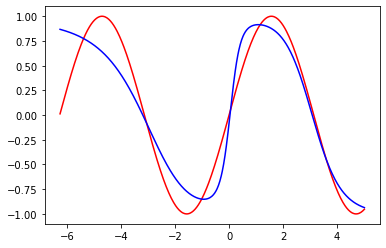

In [31]:
neural_net()

### Thank you :)